In [1]:
from dataclasses import dataclass
from datetime import datetime

import sklearn.metrics as metrics
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy import FuzzyLayer, DefuzzyLinearLayer, FuzzyBellLayer
import os
from sklearn.manifold import TSNE

import piqa

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"

In [2]:
batch_size = 256

ngf = 64
ndf = 64
fuzzy_cores = 11
latent_dim = 4
niter = 200

mnist_dissident = 0

prefix = f"fuzzy_gan_anomaly_detection"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load MNIST

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [4]:
# загружаем обучающую выборку

def get_target_and_mask(target_label):
    t = target_label
    return t 

train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)

idx = (train_data.targets != mnist_dissident)
train_data.targets = train_data.targets[idx]
train_data.data = train_data.data[idx]
len(train_data)

54077

In [5]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x))
)
len(test_data)

10000

In [6]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)


## DCGAN Model

In [7]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [8]:
class Generator(nn.Module):
    def __init__(self, ngf, fuzzy_cores, nc=1):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(fuzzy_cores, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2,     ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(    ngf,      nc, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        #fz = self.fuzzy(input)
        #fz = fz.div(fz.sum(-1).unsqueeze(-1))
        output = self.main(input.reshape((-1, fuzzy_cores, 1, 1)))
        return output

netG = Generator(ngf, fuzzy_cores).to(device)
netG.apply(weights_init)
num_params = sum(p.numel() for p in netG.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

print(netG)

Number of parameters: 2,844,608
Generator(
  (main): Sequential(
    (0): ConvTranspose2d(11, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), padding=(2, 2), bias

In [9]:
class Discriminator(nn.Module):
    def __init__(self, ndf, fuzzy_cores, latent_dim):
        
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, 4, 2, 1, bias=False),
            nn.SiLU(),
            
            nn.Conv2d(ndf, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 2, ndf * 2, 3, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 2, ndf * 4, 3, 1, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SiLU(),
            
            nn.Conv2d(ndf * 4, ndf * 4, 3, 1, 0, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.SiLU(),
            
            nn.Flatten(),
            nn.Linear(1024, latent_dim),
        )
        
        exp_k = 1            
        initial_centroids = exp_k * np.random.rand(fuzzy_cores, latent_dim)
        initial_scales =  exp_k * np.ones((fuzzy_cores, latent_dim))
        initial_pow = 1 * np.ones(fuzzy_cores)
                
        self.fuzzy = FuzzyBellLayer.from_centers_scales_and_pow(initial_centroids, initial_scales, initial_pow, trainable=True)
        
        self.defuzzy = nn.Sequential(
            DefuzzyLinearLayer.from_array(np.repeat(0.0, fuzzy_cores).reshape(1, -1), with_norm=False, trainable=True)
        )

        self.believer = nn.Sequential(
            FuzzyLayer.from_dimensions(latent_dim, fuzzy_cores),
            DefuzzyLinearLayer.from_dimensions(fuzzy_cores, 1)
        )
        
    def forward(self, input):
        output = self.main(input)
        fz = self.fuzzy(output)
        r = self.defuzzy(fz)
        blv = self.believer(output)
        
        return r.squeeze(), fz, output, blv
    

netD = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
netD.apply(weights_init)
num_params = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')
print(netD)

Number of parameters: 1,112,921
Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): SiLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): SiLU()
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): SiLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): SiLU()
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): SiLU()
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in

In [10]:
inp = torch.rand(2, 1, 28, 28).to(device)
dd = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
dd(inp)

(tensor([0., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>),
 tensor([[0.3595, 0.3073, 0.3801, 0.4270, 0.6355, 0.5322, 0.4659, 0.2861, 0.2691,
          0.4693, 0.3400],
         [0.6360, 0.4649, 0.5254, 0.6847, 0.9516, 0.8291, 0.7543, 0.5416, 0.4822,
          0.5339, 0.5115]], device='cuda:0', grad_fn=<MulBackward0>),
 tensor([[ 0.6817,  0.2177, -0.4601, -0.1570],
         [ 0.3437,  0.1060,  0.0357,  0.1619]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[0.4631],
         [0.4411]], device='cuda:0', grad_fn=<SqueezeBackward1>))

## Train

In [11]:
optimizerD = torch.optim.Adam(netD.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=2e-4, betas=(0.5, 0.999))

fixed_noise_for_report = torch.rand(49, latent_dim, device=device)

In [12]:
def keep_eigenvals_positive_loss(layer, eps = 1e-15):
    ev = layer.get_transformation_matrix_eigenvals().real.min()
    ev = torch.clamp(ev, max=eps)
    return -ev

In [13]:
ssim = piqa.SSIM(window_size=11, n_channels=1, reduction='none').to(device)


def get_test_arate_distr(D, G):
    with torch.no_grad():
        firing_levels = []
        lab_true = []
        lab_pred = []

        for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
            data = data.view((-1, 1, 28, 28)).to(device)
            
            _, fz_d, _, belief = D(data)
            #generated_image = G.main(fz_d.reshape((-1, fuzzy_cores, 1, 1)))
            
            #data = data - data.min(dim=1).values.min()
            #data = data/data.max(dim=1).values.max()
            
            #generated_image = generated_image - generated_image.min(dim=1).values.min()
            #generated_image = generated_image / generated_image.max(dim=1).values.max()
            
            #diff = ssim(data, generated_image)#1 - torch.cosine_similarity(data.flatten(start_dim=1), generated_image.flatten(start_dim=1))
            rates = (1 - belief).abs().detach().cpu().numpy()
            
            for f, l in  zip(rates, lab):
                firing_levels.append(f)
                lab_pred.append(f)        
                if l == mnist_dissident:
                    lab_true.append(1)
                else:
                    lab_true.append(0)
                        
        fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
        roc_auc = metrics.auc(fpr, tpr)
        firing_levels = np.array(firing_levels)
        return firing_levels, roc_auc, threshold

def draw_embeddings(netD, netG, epoch):
    with torch.no_grad():
        centroids_real = netD.fuzzy.get_centroids().detach().cpu().numpy()

        embedings_test = []
        labels_expected = []
            
        for data, target in tqdm(test_loader, desc='Encoding', disable=True):
            data = data.view((-1,1,28,28)).to(device)
            embeding = netD.main(data)
            embedings_test.append(embeding.cpu().numpy())
            labels_expected.append(target)
        
        embedings_test = np.concatenate(embedings_test, axis=0)
        labels_expected = np.concatenate(labels_expected, axis=0)
        
        embedings_fake = []

        inp_g = netD.fuzzy(fixed_noise_for_report).detach()
        fake_images = netG(inp_g)
        embeding = netD.main(fake_images)
        embedings_fake.append(embeding.cpu().numpy())

        embedings_fake = np.concatenate(embedings_fake, axis=0)    

        fig = plt.figure(layout='constrained', figsize=(13, 4))
        subfigs = fig.subfigures(1, 3, wspace=0.07)
        axsLeft = subfigs[0].subplots(1, 1, sharey=True)

        axsLeft.scatter(embedings_test[:, 0], embedings_test[:, 1], cmap='tab10', c=labels_expected, s=1)
        axsLeft.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=120)
        axsLeft.scatter(centroids_real[:, 0], centroids_real[:, 1], marker='1', c='black', s= 30)
        
        axsLeft = subfigs[1].subplots(1, 1, sharey=True)
        axsLeft.scatter(embedings_test[:, 0], embedings_test[:, 2], cmap='tab10', c=labels_expected, s=1)
        axsLeft.scatter(embedings_fake[:, 0], embedings_fake[:, 2], c='black', marker='o', s=2)
        
        fake_images_np = fake_images.cpu().detach().numpy()
        fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
        axsRight = subfigs[2].subplots(7, 7, sharey=True)
        i = 0
        for x in axsRight:
            for y in x:
                y.imshow(fake_images_np[i], cmap='gray')
                y.axis('off')
                i += 1
        plt.show()
        writer.add_figure('Embeddings', fig, epoch)

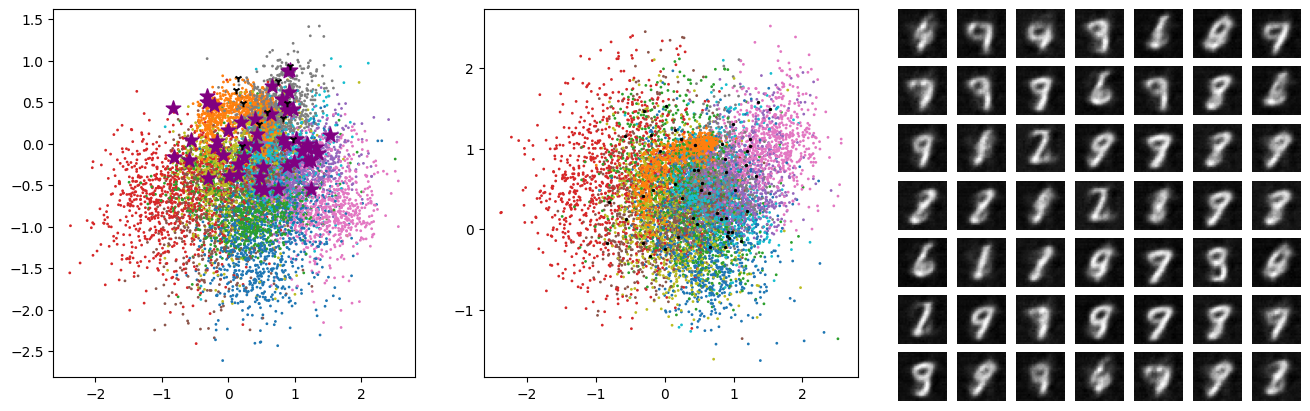

Epoch 0/200 {'AUC': 0.3145329539798181, 'G': 0.7008477054395765, 'POS': 0.13553317483703448, 'NEG': 0.17491153228966483, 'EV': 0.0, 'REGEN': 44.67029355606943, 'BELIEF': 0.144477035639421}
Epoch 1/200 {'G': 0.35166410736317905, 'POS': 0.37984574136306654, 'NEG': 0.4221575052108405, 'EV': 0.0, 'REGEN': 29.93233931739375, 'BELIEF': 0.07504241103482134}
Epoch 2/200 {'G': 0.2656494890743831, 'POS': 0.48041400102511894, 'NEG': 0.5050855711945947, 'EV': 0.0, 'REGEN': 26.890671037278086, 'BELIEF': 0.03501356095251328}


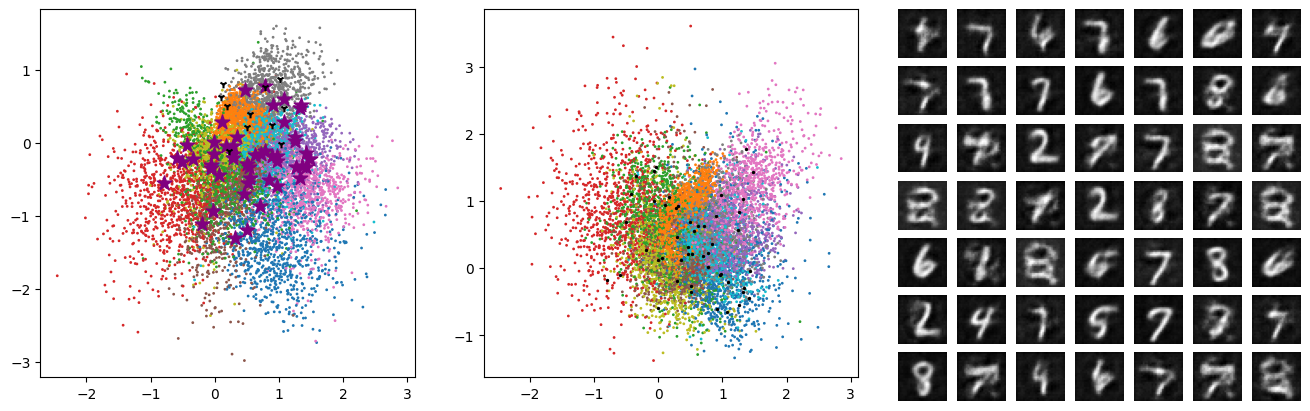

Epoch 3/200 {'AUC': 0.3367962351237613, 'G': 0.24256141589216465, 'POS': 0.5342268995800108, 'NEG': 0.5231921284828546, 'EV': 0.0, 'REGEN': 25.402988343868614, 'BELIEF': 0.015298898195637003}
Epoch 4/200 {'G': 0.23558228245040155, 'POS': 0.5574132476775151, 'NEG': 0.5346399511931077, 'EV': 0.0, 'REGEN': 24.296299142657585, 'BELIEF': 0.0064465815293655365}
Epoch 5/200 {'G': 0.24393123711617487, 'POS': 0.5620782819558989, 'NEG': 0.5286005153408591, 'EV': 0.0, 'REGEN': 23.52572358329341, 'BELIEF': 0.0032701994916248434}


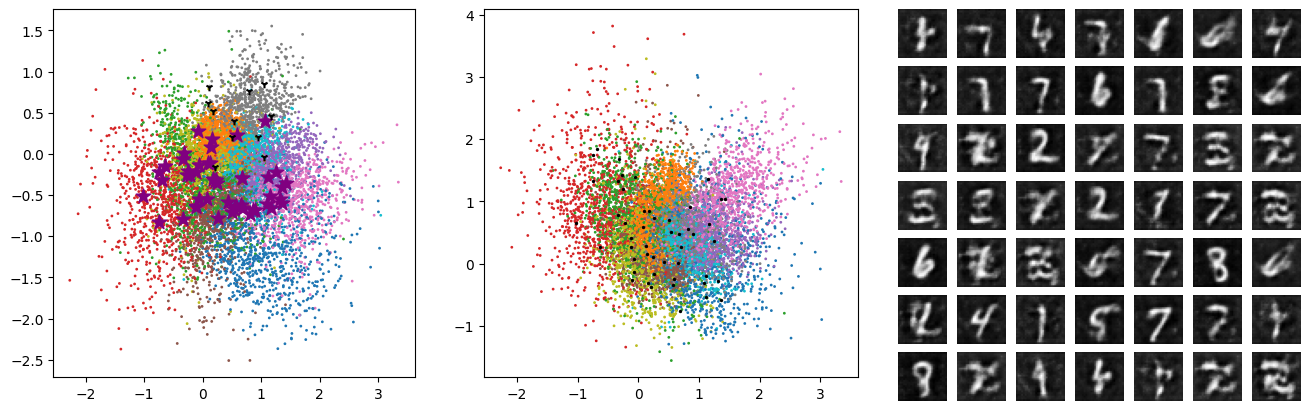

Epoch 6/200 {'AUC': 0.4598261799176433, 'G': 0.23729824998749877, 'POS': 0.5771122372375345, 'NEG': 0.5325596329738509, 'EV': 0.0, 'REGEN': 22.87548022000295, 'BELIEF': 0.0021326081148559614}
Epoch 7/200 {'G': 0.23380070685778023, 'POS': 0.5790219304134261, 'NEG': 0.5382611987725744, 'EV': 0.0, 'REGEN': 22.39373174703346, 'BELIEF': 0.0015333101168749327}
Epoch 8/200 {'G': 0.22865910849200105, 'POS': 0.5557399324651034, 'NEG': 0.5504390608589604, 'EV': 0.0, 'REGEN': 21.908805676226347, 'BELIEF': 0.0011315235779137474}


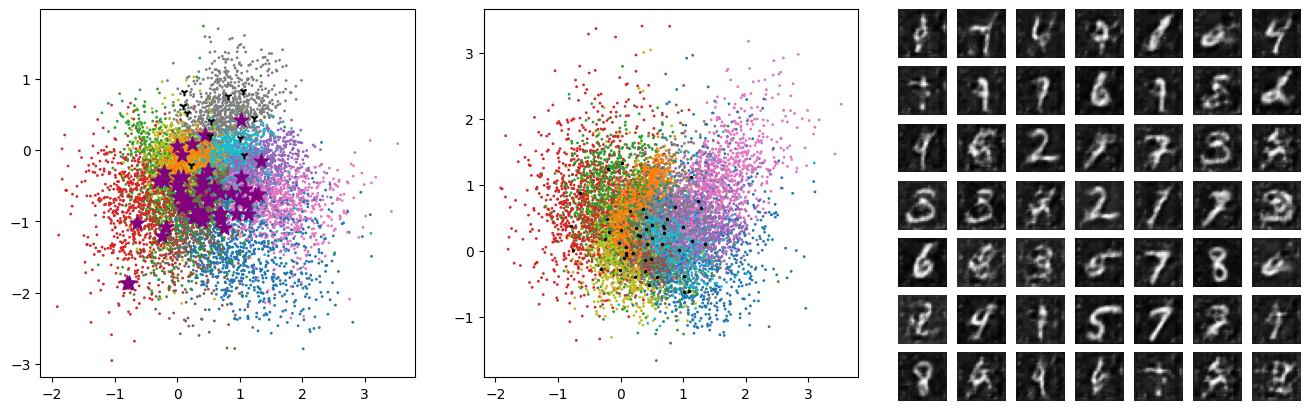

Epoch 9/200 {'AUC': 0.5124243744060817, 'G': 0.23554514692920558, 'POS': 0.5456805418965951, 'NEG': 0.5420976348643033, 'EV': 0.0, 'REGEN': 21.524261339655464, 'BELIEF': 0.0008087113847239998}
Epoch 10/200 {'G': 0.23765368176237592, 'POS': 0.5513732357407516, 'NEG': 0.5391265069538692, 'EV': 0.0, 'REGEN': 21.22599722304434, 'BELIEF': 0.0005435201045365143}
Epoch 11/200 {'G': 0.2384093816409696, 'POS': 0.5525477497645144, 'NEG': 0.5425773409177672, 'EV': 0.0, 'REGEN': 20.94351824274603, 'BELIEF': 0.0003485401850309056}


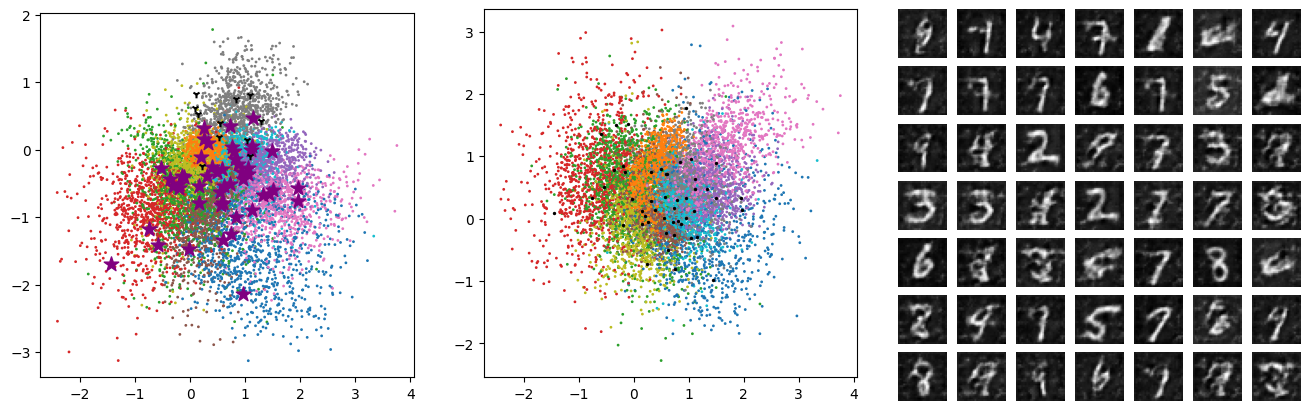

Epoch 12/200 {'AUC': 0.5730555681252546, 'G': 0.24113733012158917, 'POS': 0.5535811891533294, 'NEG': 0.538883461142486, 'EV': 0.0, 'REGEN': 20.649445704694063, 'BELIEF': 0.00020447188117546865}
Epoch 13/200 {'G': 0.24049403574669137, 'POS': 0.5484853794552246, 'NEG': 0.5396202290957829, 'EV': 0.0, 'REGEN': 20.40842337878245, 'BELIEF': 0.00011984115821487305}
Epoch 14/200 {'G': 0.2430766444864138, 'POS': 0.5788546300159311, 'NEG': 0.535937784415371, 'EV': 0.0, 'REGEN': 20.222364263714486, 'BELIEF': 7.572774468843698e-05}


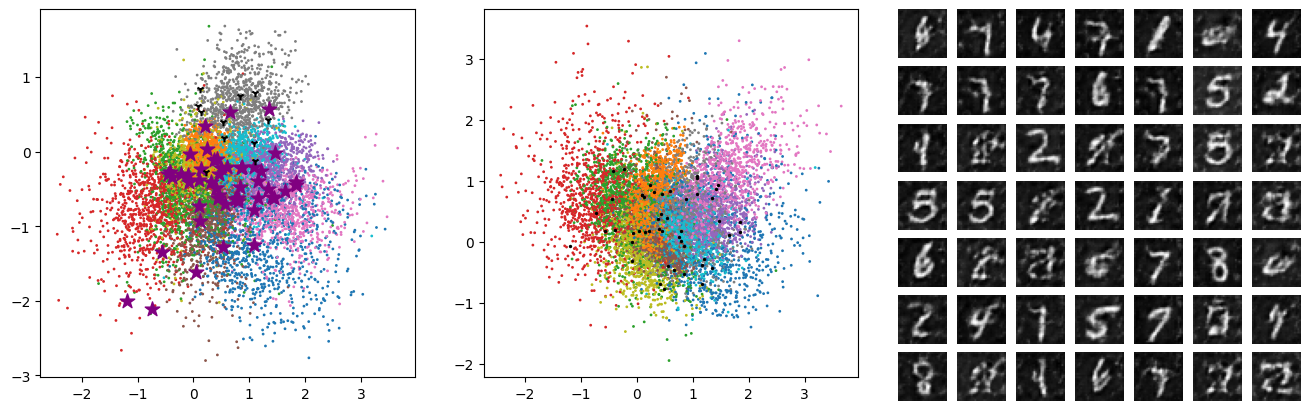

Epoch 15/200 {'AUC': 0.5565141522240826, 'G': 0.23784759204904987, 'POS': 0.5476402972104415, 'NEG': 0.5452913433875678, 'EV': 0.0, 'REGEN': 20.007146016606743, 'BELIEF': 5.253627779962218e-05}
Epoch 16/200 {'G': 0.24003061757616276, 'POS': 0.5501827220871763, 'NEG': 0.539172056429791, 'EV': 0.0, 'REGEN': 19.847111611996056, 'BELIEF': 3.817363620946021e-05}
Epoch 17/200 {'G': 0.24152694635514943, 'POS': 0.5584311153528825, 'NEG': 0.5357968659614617, 'EV': 0.0, 'REGEN': 19.62707013004231, 'BELIEF': 3.0379132988186166e-05}


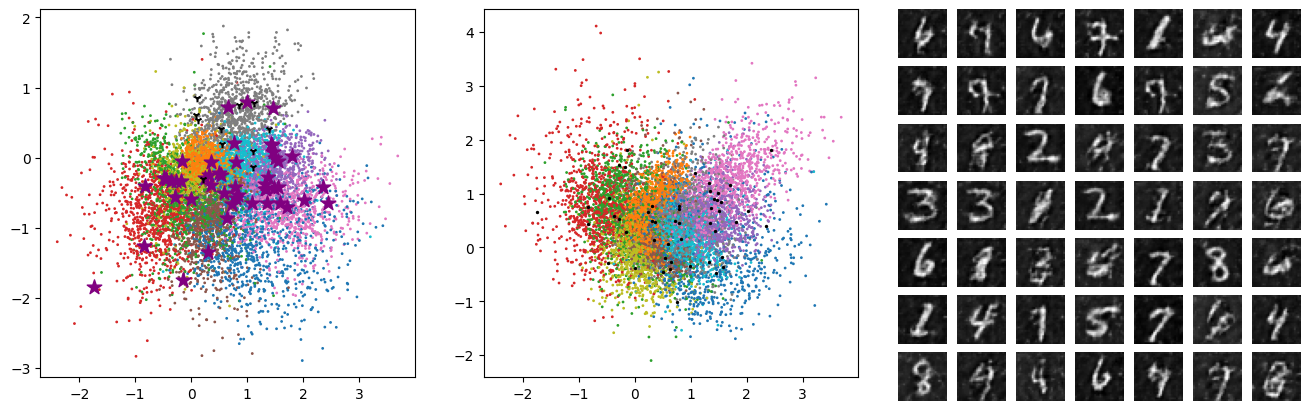

Epoch 18/200 {'AUC': 0.592744807457351, 'G': 0.24420473865180645, 'POS': 0.5682655376083446, 'NEG': 0.5359613864489321, 'EV': 0.0, 'REGEN': 19.464663226649446, 'BELIEF': 2.3848563524500964e-05}
Epoch 19/200 {'G': 0.237959650679017, 'POS': 0.5617870665946096, 'NEG': 0.5430726469406542, 'EV': 0.0, 'REGEN': 19.36292119296092, 'BELIEF': 1.903330401563715e-05}
Epoch 20/200 {'G': 0.24550689124273803, 'POS': 0.5747066744655933, 'NEG': 0.5331023528047327, 'EV': 0.0, 'REGEN': 19.218681821283305, 'BELIEF': 1.5262476707439935e-05}


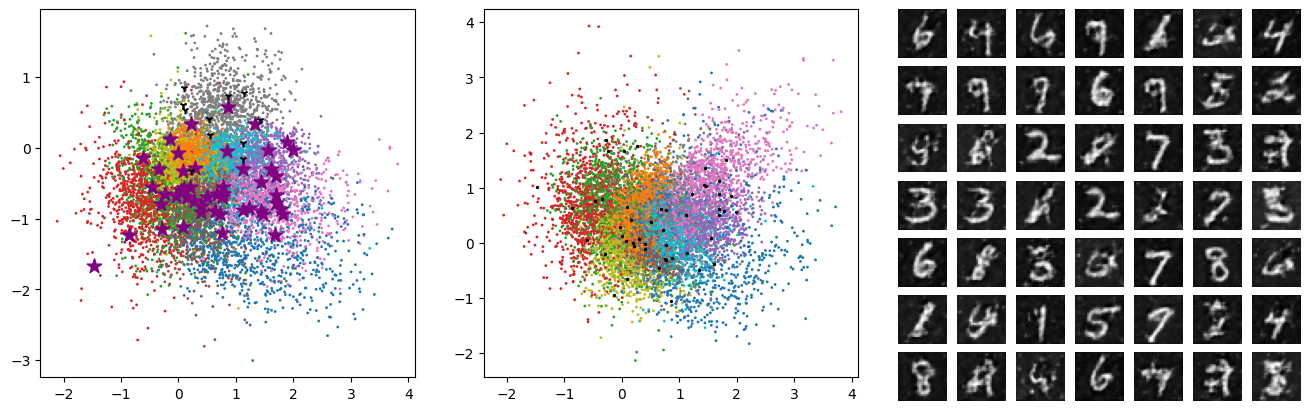

Epoch 21/200 {'AUC': 0.6322230643920539, 'G': 0.24255370404922738, 'POS': 0.5791563827474162, 'NEG': 0.5353819377860933, 'EV': 0.0, 'REGEN': 19.029537119955386, 'BELIEF': 1.2443311389980186e-05}
Epoch 22/200 {'G': 0.2428562455582169, 'POS': 0.5840206320555705, 'NEG': 0.5346375577292353, 'EV': 0.0, 'REGEN': 18.929522019512248, 'BELIEF': 9.922270968895904e-06}
Epoch 23/200 {'G': 0.23804331514632926, 'POS': 0.6074414078919392, 'NEG': 0.538290298772308, 'EV': 0.0, 'REGEN': 18.84695631603025, 'BELIEF': 7.391614391688666e-06}


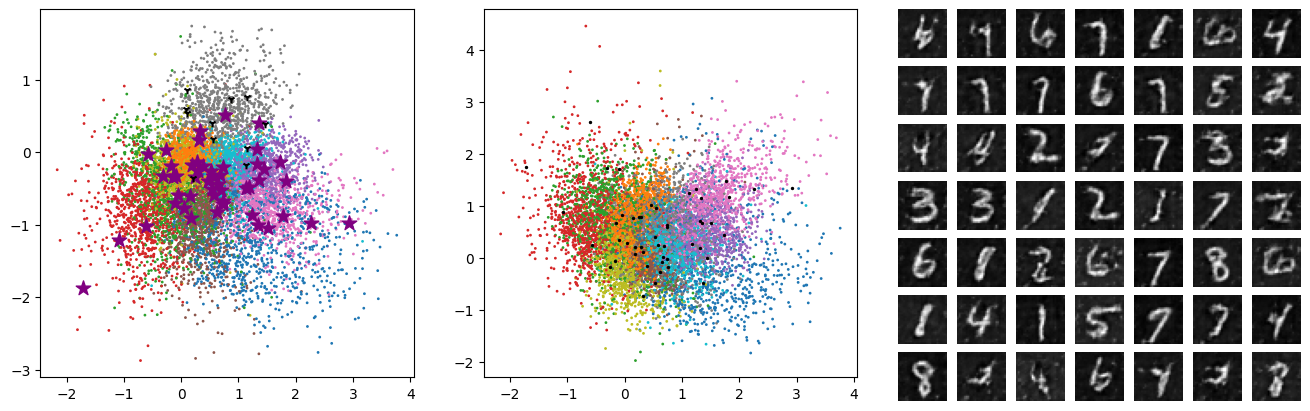

Epoch 24/200 {'AUC': 0.6252974116475858, 'G': 0.24562215552015124, 'POS': 0.5915001692636958, 'NEG': 0.5357852483976562, 'EV': 0.0, 'REGEN': 18.65061663681606, 'BELIEF': 6.51030253901002e-06}
Epoch 25/200 {'G': 0.2279021808139558, 'POS': 0.5708534096209508, 'NEG': 0.5536693641037311, 'EV': 0.0, 'REGEN': 18.690549211682015, 'BELIEF': 5.014604931079273e-06}
Epoch 26/200 {'G': 0.22845198677958184, 'POS': 0.5660229538971523, 'NEG': 0.5435726119662231, 'EV': 0.0, 'REGEN': 18.488326918404056, 'BELIEF': 4.002899429515996e-06}


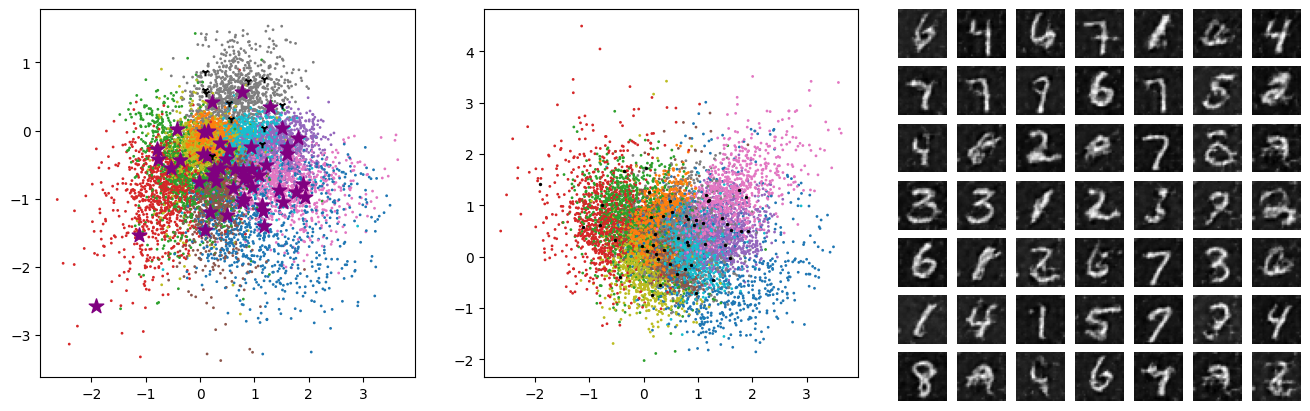

Epoch 27/200 {'AUC': 0.6616023349472827, 'G': 0.23306178153966958, 'POS': 0.5692140935164578, 'NEG': 0.5395825589602848, 'EV': 0.0, 'REGEN': 18.34217046341806, 'BELIEF': 3.465984979944757e-06}
Epoch 28/200 {'G': 0.23900448559027798, 'POS': 0.584572323088376, 'NEG': 0.5363167222097235, 'EV': 0.0, 'REGEN': 18.28817956852463, 'BELIEF': 2.843059493623617e-06}
Epoch 29/200 {'G': 0.24307232912418977, 'POS': 0.5875549456983242, 'NEG': 0.5363303422927856, 'EV': 0.0, 'REGEN': 18.229402470138837, 'BELIEF': 2.428979294731073e-06}


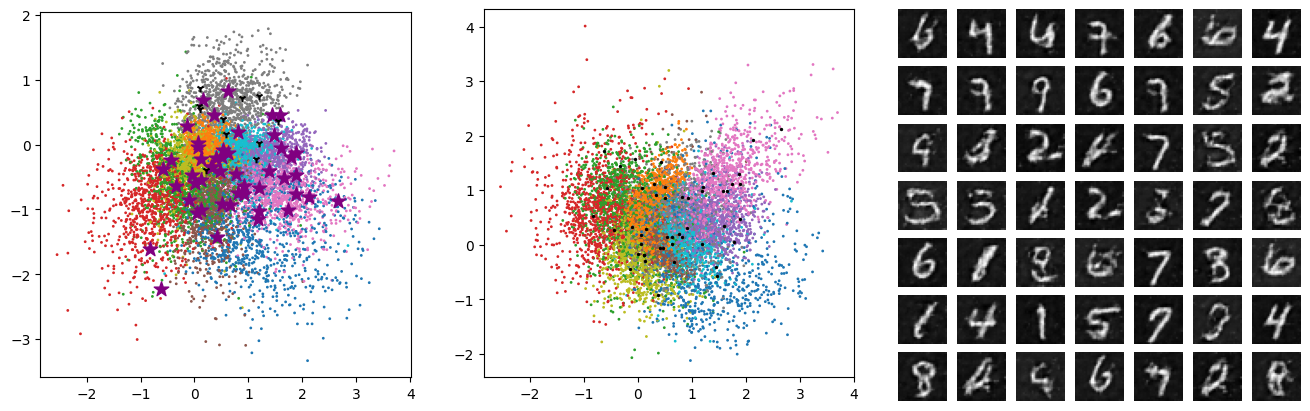

Epoch 30/200 {'AUC': 0.7355887709851125, 'G': 0.24161519876347398, 'POS': 0.5925526090388028, 'NEG': 0.5381453527875666, 'EV': 0.0, 'REGEN': 18.097595889613313, 'BELIEF': 2.0037748787187396e-06}
Epoch 31/200 {'G': 0.23863207028721864, 'POS': 0.5888256759576078, 'NEG': 0.539936362994167, 'EV': 0.0, 'REGEN': 18.049345394350446, 'BELIEF': 1.5835471549722432e-06}
Epoch 32/200 {'G': 0.2400617352071798, 'POS': 0.5931768591673869, 'NEG': 0.5402756698851315, 'EV': 0.0, 'REGEN': 17.945254622765308, 'BELIEF': 1.2802683538891543e-06}


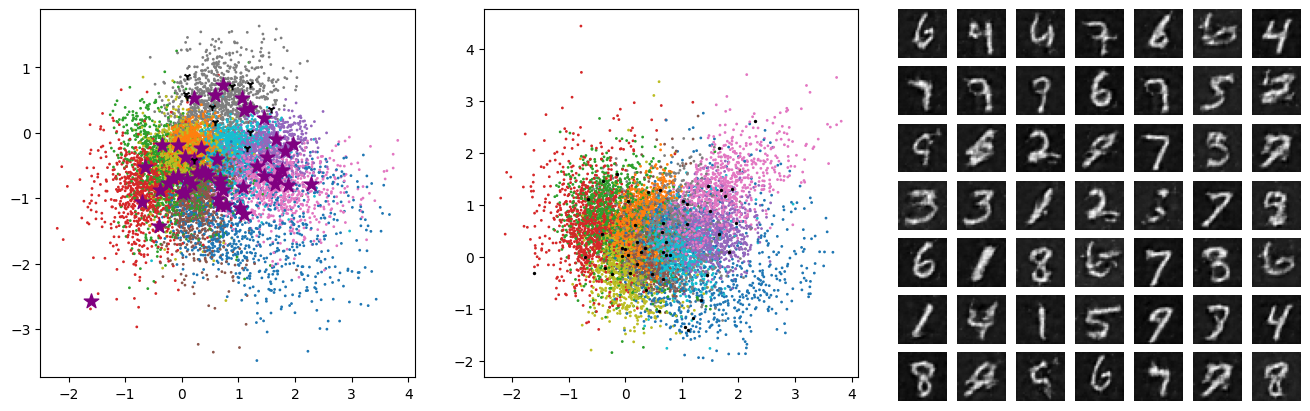

Epoch 33/200 {'AUC': 0.7739595683062583, 'G': 0.2358728178407786, 'POS': 0.5885082202137641, 'NEG': 0.5418404568478746, 'EV': 0.0, 'REGEN': 17.88867716519338, 'BELIEF': 1.1051310002800026e-06}
Epoch 34/200 {'G': 0.2237563376437943, 'POS': 0.583184614215257, 'NEG': 0.553196592291571, 'EV': 0.0, 'REGEN': 17.84150247753791, 'BELIEF': 8.404523534145397e-07}
Epoch 35/200 {'G': 0.2488550969733382, 'POS': 0.5958810094392525, 'NEG': 0.5283268390680259, 'EV': 0.0, 'REGEN': 17.693951975624515, 'BELIEF': 6.740440641027697e-07}


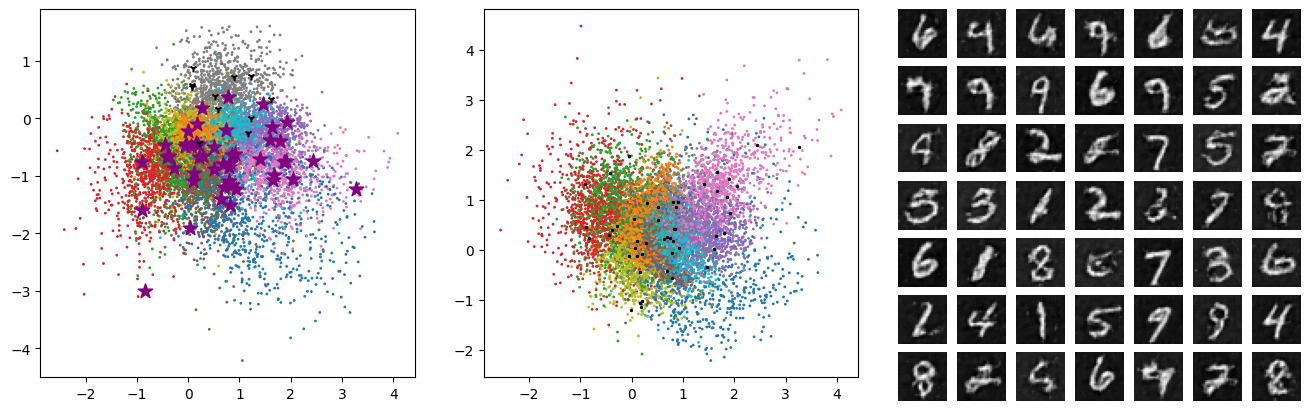

Epoch 36/200 {'AUC': 0.7877424883478892, 'G': 0.2380996157397639, 'POS': 0.605315701297994, 'NEG': 0.5402458571600464, 'EV': 0.0, 'REGEN': 17.73107117526936, 'BELIEF': 5.937638989289038e-07}
Epoch 37/200 {'G': 0.2323978695104707, 'POS': 0.5858341264274886, 'NEG': 0.5445409069927234, 'EV': 0.0, 'REGEN': 17.58602599377902, 'BELIEF': 4.954379190843705e-07}
Epoch 38/200 {'G': 0.2375148392089133, 'POS': 0.5986606810452804, 'NEG': 0.5395432617866768, 'EV': 0.0, 'REGEN': 17.482451816774763, 'BELIEF': 4.2968325323795825e-07}


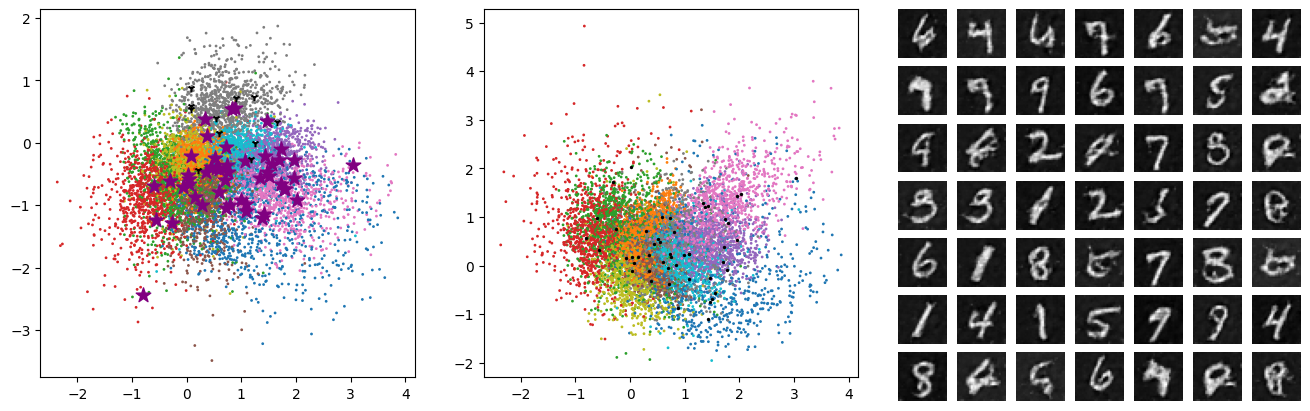

Epoch 39/200 {'AUC': 0.7590363251730847, 'G': 0.23747548453931538, 'POS': 0.6037819084693801, 'NEG': 0.5404987458912831, 'EV': 0.0, 'REGEN': 17.412146559301412, 'BELIEF': 3.6348131421288413e-07}
Epoch 40/200 {'G': 0.22292762073986935, 'POS': 0.5927016535457575, 'NEG': 0.5537113215563432, 'EV': 0.0, 'REGEN': 17.419643465078103, 'BELIEF': 3.265213931688601e-07}
Epoch 41/200 {'G': 0.2343473033100929, 'POS': 0.5983705798972327, 'NEG': 0.5401324573552834, 'EV': 0.0, 'REGEN': 17.343531280193687, 'BELIEF': 2.5405117040685675e-07}


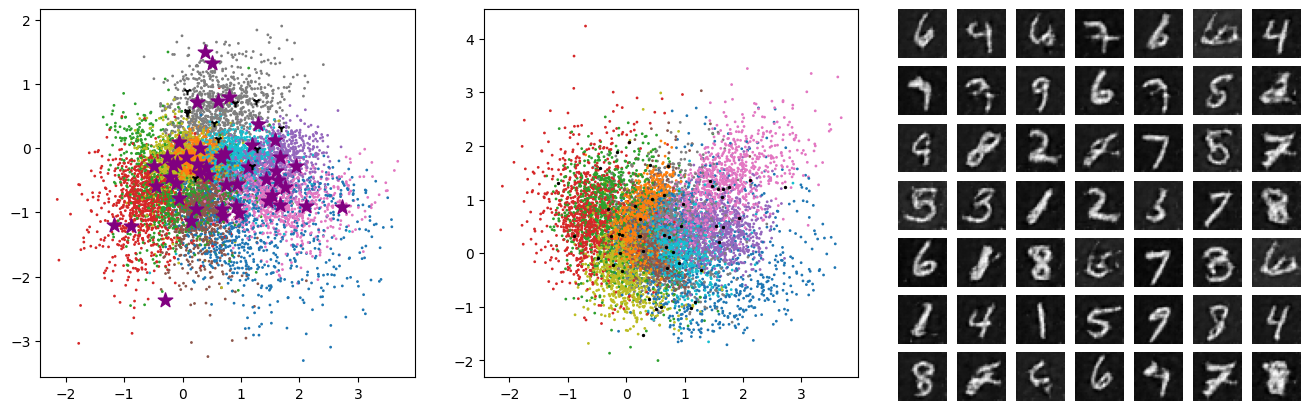

Epoch 42/200 {'AUC': 0.736434114665822, 'G': 0.23772663285709777, 'POS': 0.5987306630836343, 'NEG': 0.5404538888976259, 'EV': 0.0, 'REGEN': 17.222199732402586, 'BELIEF': 2.423898690986233e-07}


KeyboardInterrupt: 

In [14]:
netG.train()
netD.train()

for epoch in range(niter):
    report_aver_pos = 0
    report_aver_neg = 0
    report_loss_G = 0
    report_loss_regen = 0
    report_loss_belief = 0
    report_ev = 0
    local_count = 0
    
    for i, data in enumerate(tqdm(train_loader, desc='Training', disable=True)):
        real_cpu = data[0].to(device)
        batch_size = real_cpu.size(0)
        netD.zero_grad()
        netG.zero_grad()
        
        noise = torch.rand(batch_size, latent_dim, device=device)
        inp_g = netD.fuzzy(noise).detach()
        fake = netG(inp_g)
        
        firing_r, _, _, blv = netD(real_cpu)
        limit_real = (1.00 + 0.02 * (1 - 2*torch.rand(batch_size))).to(device)
        errD_real = torch.square(limit_real - firing_r).mean() 
        errD_real.backward(retain_graph=True)
        error_belief = (1 - blv).square().mean()
        error_belief.backward()
        
        nfiring_r, _, _, _ = netD(fake.detach())
        errD_fake = (nfiring_r).square().mean()
        errD_fake.backward()
        
        ev_loss = keep_eigenvals_positive_loss(netD.fuzzy)
        report_ev = np.maximum(report_ev, ev_loss.item())
        if ev_loss.item() > 0:
            ev_loss.backward()
        
        optimizerD.step()
        
        fz_genr,_, _, _ = netD(fake)
        errG = (1 - fz_genr).square().mean()
        errG.backward()
        
        optimizerG.step()
        
        _, fz_d_real, _, _ = netD(real_cpu)
        regen = netG(fz_d_real)
        regen_loss = (real_cpu - regen).square().sum(-1).sum(-1).mean()
        regen_loss.backward()
        optimizerG.step()
        optimizerD.step()    
        report_loss_regen += regen_loss.item()

        local_count += 1
        report_loss_G += errG.item()
        report_aver_pos += firing_r.mean().item()
        report_aver_neg += nfiring_r.mean().item()
        report_loss_belief += error_belief.item()
        
    with torch.no_grad():
        losses = {}
        if epoch % 3 == 0:
            firings, auc, threshold = get_test_arate_distr(netD, netG)
            losses['AUC'] = auc
            draw_embeddings(netD, netG, epoch)

        losses['G'] = report_loss_G / local_count
        losses['POS'] = report_aver_pos / local_count
        losses['NEG'] = report_aver_neg / local_count
        losses['EV'] = report_ev
        losses['REGEN'] = report_loss_regen / local_count
        losses['BELIEF'] = report_loss_belief / local_count
        
        writer.add_scalars('Loss', losses, epoch)
        print(f"Epoch {epoch}/{niter} {losses}")
    

In [15]:
torch.save(netD.state_dict(), f'weights/netD_{mnist_dissident}.pth')
torch.save(netG.state_dict(), f'weights/netG_{mnist_dissident}.pth')

## Валидация

In [16]:
D = Discriminator(ndf, fuzzy_cores, latent_dim).to(device)
G = Generator(ngf, fuzzy_cores).to(device)
D.load_state_dict(torch.load(f'weights/netD_{mnist_dissident}.pth'))
G.load_state_dict(torch.load(f'weights/netG_{mnist_dissident}.pth'))
#DO NOT USE EVAL

<All keys matched successfully>

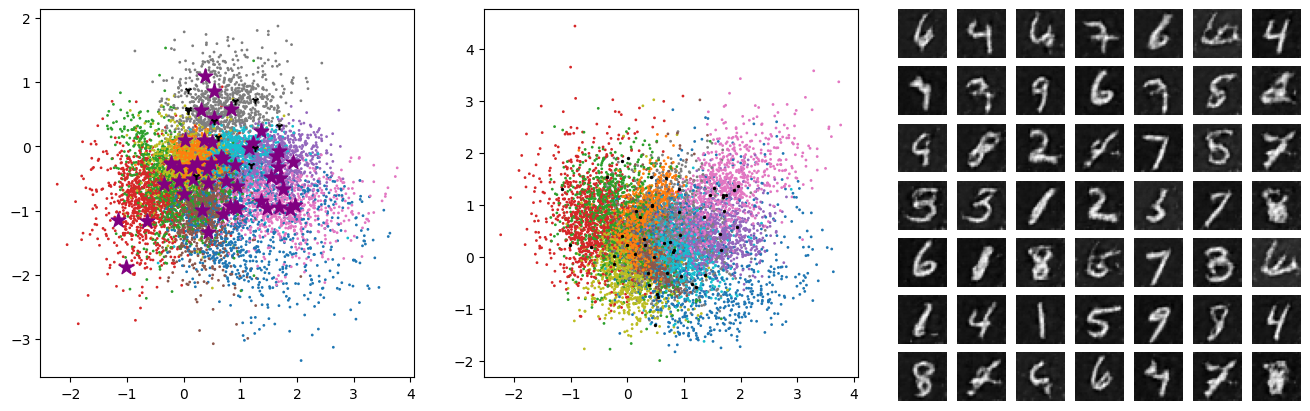

In [17]:
draw_embeddings(D, G, niter)

In [18]:
firings, auc, threshold = get_test_arate_distr(D,G)
print(F"Average firing {firings.mean()}")
print(F"AUC {auc} Threshold {threshold}")


Average firing 0.00026094404165633023
AUC 0.7182038214398841 Threshold [          inf 1.0223508e-02 5.7513714e-03 ... 1.7881393e-07 1.1920929e-07
 0.0000000e+00]


In [19]:
# with torch.no_grad():
#     R, C = 10, 10
#     x = np.linspace(0.0, 1.0, R*C)
#     y = 0.3*x+0.7

#     noise = torch.FloatTensor(np.dstack((x,y))).reshape((-1,nz)).to(device)
#     fake_images, _ = G(noise)
#     fake_images_np = fake_images.cpu().detach().numpy()
#     fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    
#     embedings = D.main(fake_images).cpu().numpy()
        
    
#     for i in range(R*C):
#         plt.subplot(R, C, i + 1)
#         plt.imshow(fake_images_np[i], cmap='gray')
#     plt.show()
#     plt.scatter(embedings[:,0],embedings[:,1], s=2)

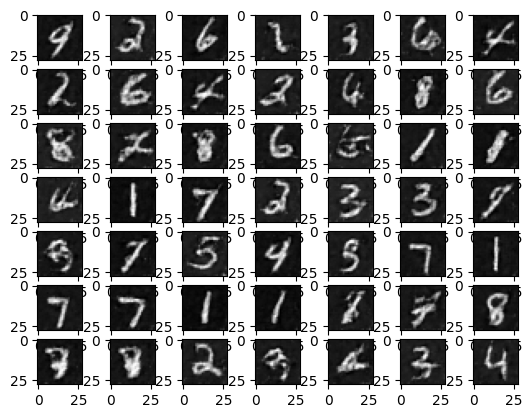

In [20]:
with torch.no_grad():
    
    noise = torch.rand(49, latent_dim, device=device)
    inp_g = netD.fuzzy(noise).detach()
    fake_images = netG(inp_g)

    fake_images_np = fake_images.cpu().detach().numpy()
    fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
    R, C = 7, 7
    for i in range(49):
        plt.subplot(R, C, i + 1)
        plt.imshow(fake_images_np[i], cmap='gray')
    plt.show()

In [21]:
def get_arate(inp):
    _, fz_d, _, _ = D(inp)
    generated_image = G.main(fz_d.reshape((-1, fuzzy_cores, 1, 1)))
    
    data = inp
    data = data - data.min(dim=1).values.min()
    data = data/data.max(dim=1).values.max()
    
    generated_image = generated_image - generated_image.min(dim=1).values.min()
    generated_image = generated_image / generated_image.max(dim=1).values.max()
    
    diff = ssim(data, generated_image)#1 - torch.cosine_similarity(data.flatten(start_dim=1), generated_image.flatten(start_dim=1))
    rates = 1-diff.detach().cpu().numpy()
    #rates = torch.where(diff > 0.5, 1.0, 0.0).mean(-1).mean(-1).squeeze()
    #diff = (inp-generated_image).squeeze().sum(-1).sum(-1)
    #rates = diff.detach().cpu().numpy()
    
    
    return rates#(1-fz_d.sum(-1)).abs().detach().cpu().numpy() #torch.square(fz_d - fz_g).sum(-1).detach().cpu().numpy()#fz_d.max(-1).values.detach().cpu().numpy() ##torch.cosine_similarity(fz_d, fz_g, dim=-1).detach().cpu().numpy()#(rd+rg-rd*rg).detach().cpu().numpy()#torch.square(embd1 - embd2).sum(-1).detach().cpu().numpy()# # # #

inp = torch.rand((10,1,28,28))
get_arate(inp.to(device))

array([0.9135071 , 0.96341074, 0.9867754 , 0.98327506, 0.94395727,
       1.0007544 , 0.9862798 , 0.9815198 , 0.99123657, 0.9639324 ],
      dtype=float32)

In [22]:
centroids_r = D.fuzzy.get_centroids().detach().cpu().numpy()
centroids_r

array([[ 0.9042959 ,  0.70828074, -0.05883025,  1.1616156 ],
       [ 1.2636046 , -0.02076462,  0.85337466,  1.552347  ],
       [ 0.60310715,  0.14533423,  0.978582  ,  0.04112995],
       [ 0.08224297,  0.5841707 , -0.10756054,  0.33595693],
       [ 0.20739283, -0.45884883,  1.3646032 ,  0.65745836],
       [ 0.52983725,  0.39790723,  1.308545  ,  1.3986424 ],
       [ 0.07928608,  0.88416684,  0.44484425,  0.5950904 ],
       [ 1.1850134 , -0.28214708,  0.3025925 ,  0.4684607 ],
       [ 1.2500777 ,  0.72842634,  0.8598989 ,  0.3016042 ],
       [ 0.07600633,  0.54916483,  0.8655466 ,  0.05660667],
       [ 1.6804881 ,  0.31875983,  1.45946   ,  1.1645942 ]],
      dtype=float32)

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

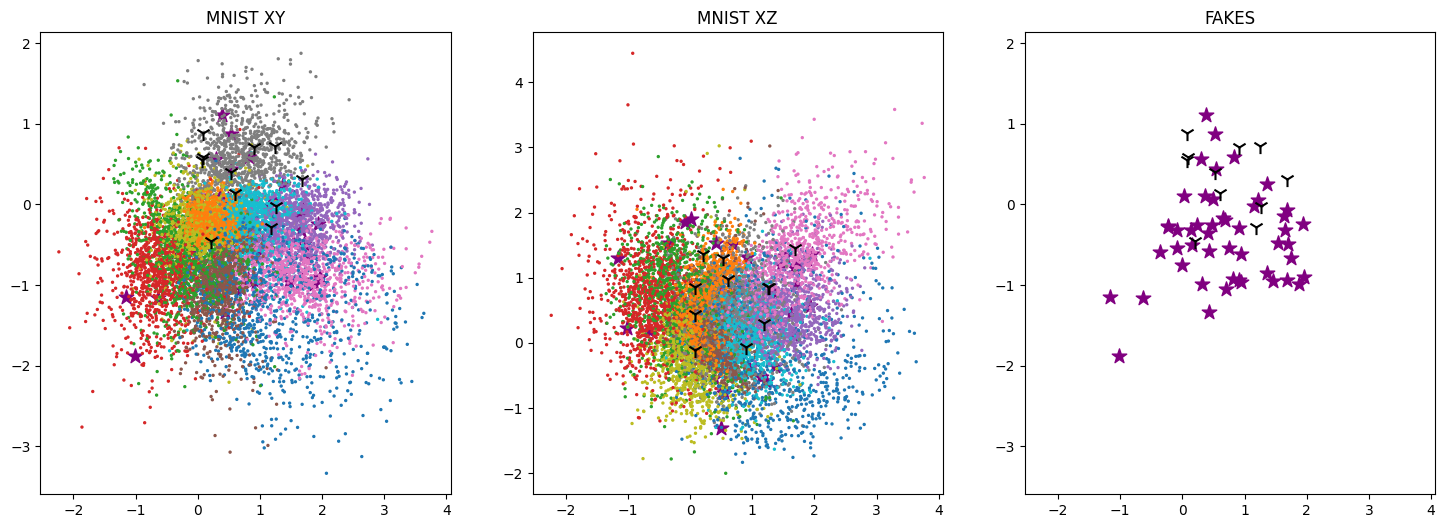

In [23]:
embedings_fake = []

with torch.no_grad():
    batch_size = 256
    
    inp_g = netD.fuzzy(fixed_noise_for_report).detach()
    fake_images = G(inp_g)
    
    embeding = D.main(fake_images)
    embedings_fake.append(embeding.cpu().numpy())

embedings_fake = np.concatenate(embedings_fake, axis=0)    

embedings = []
labels_expected = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        embeding = D.main(data)
        embedings.append(embeding.cpu().numpy())
        labels_expected.append(target.cpu().numpy())
embedings = np.concatenate(embedings, axis=0)
labels_expected = np.concatenate(labels_expected, axis=0)

plt.figure(figsize=(18, 6))

R, C = 1, 3

plt.subplot(R, C, 1)
plt.title("MNIST XY")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=120)
plt.scatter(embedings[:, 0],      embedings[:,  1], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,1], marker='1', c='black', s= 120)
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
plt.subplot(R, C, 2)
plt.title("MNIST XZ")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 2], c='purple', marker='*', s=120)
plt.scatter(embedings[:, 0],      embedings[:,  2], c=labels_expected, cmap='tab10', s=2)
plt.scatter(centroids_r[:, 0],    centroids_r[:,2], marker='1', c='black', s= 120)

plt.subplot(R, C, 3)
plt.title("FAKES")
plt.scatter(embedings_fake[:, 0], embedings_fake[:, 1], c='purple', marker='*', s=120)
plt.scatter(centroids_r[:, 0], centroids_r[:, 1], marker='1', c='black', s= 120)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.show()

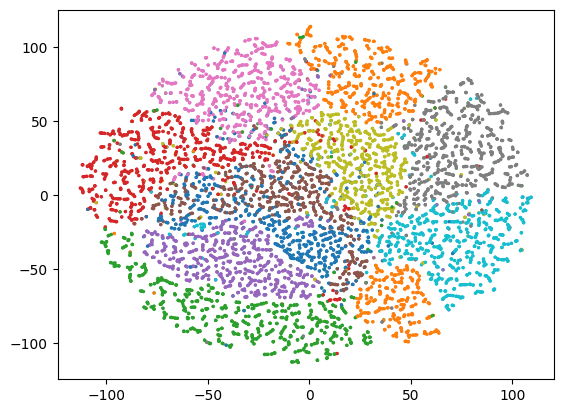

In [24]:
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3).fit_transform(embedings)
plt.scatter(X_embedded[:, 0],      X_embedded[:,  1], c=labels_expected, cmap='tab10', s=2)

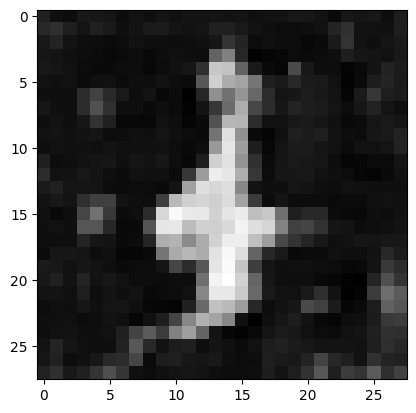

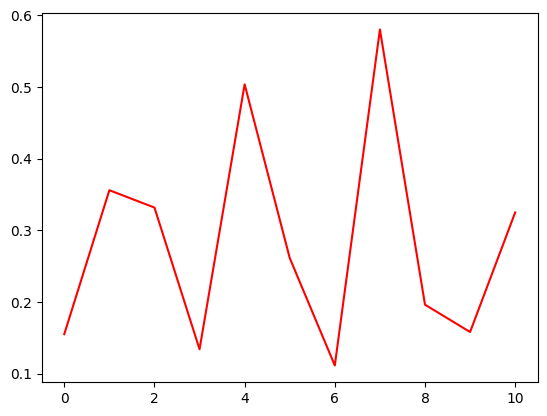

In [25]:
fixed_noise = torch.rand(1, latent_dim)
if torch.cuda.is_available():
    fixed_noise = fixed_noise.cuda()
inp_g = D.fuzzy(fixed_noise).detach()
fake_images = G(inp_g)


_, fzd,_,_ = D(fake_images)
fake_images_np = fake_images.cpu().detach().numpy()
fake_images_np = fake_images_np.reshape(fake_images_np.shape[0], 28, 28)
plt.imshow(fake_images_np[0], cmap='gray')
plt.show()
plt.plot(fzd[0].detach().cpu().numpy(), c="red")

MNIST HIST:   0%|          | 0/40 [00:00<?, ?it/s]

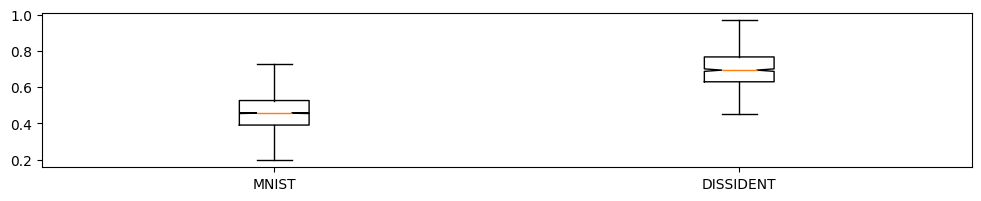

In [26]:
firings_mnist = {}
firings_mnist['MNIST'] = []
firings_mnist['DISSIDENT'] = []

with torch.no_grad():
    for data, target in tqdm(test_loader, desc='MNIST HIST'):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        for f, l in  zip(rates, target):
            if l != mnist_dissident:
                firings_mnist['MNIST'].append(f)
            else:
                firings_mnist['DISSIDENT'].append(f)
        

labels, data = firings_mnist.keys(), firings_mnist.values()

fig = plt.figure(figsize =(12, 2))
plt.boxplot(data, notch=True, showfliers=False)
plt.xticks(range(1, len(labels) + 1), labels)
plt.show()

writer.add_figure('Anomaly Detection', fig)

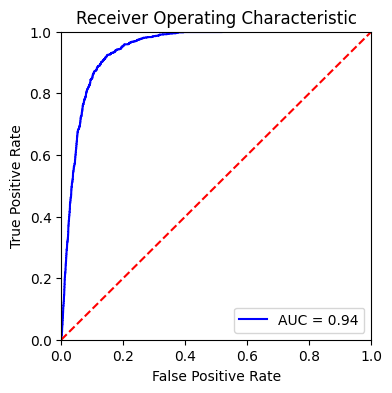

In [27]:
with torch.no_grad():
    firing_levels = []
    lab_true = []
    lab_pred = []

    for data, lab in tqdm(test_loader, desc='Test MNIST', disable=True):
        data = data.view((-1,1,28,28)).to(device)
        rates = get_arate(data)
        
        for f, l in  zip(rates, lab):
            firing_levels.append(f)
            lab_pred.append(f)        
            if l == mnist_dissident:
                lab_true.append(1)
            else:
                lab_true.append(0)
                    
    fpr, tpr, threshold = metrics.roc_curve(lab_true, lab_pred)
    roc_auc = metrics.auc(fpr, tpr)
    
    fig = plt.figure(figsize =(4, 4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    writer.add_figure('ROC', fig)

In [28]:
def find_best_binary_auc_threshold(binary_thresholds,
                               fp_rate,
                               recall,
                               proportion_positive_case: float = 0.5,
                               cost_false_positive: float = 0.5,
                               cost_false_negative: float = 0.5,
                               argmin_axis: int = 0):
    isocost_lines = cost_false_positive * (1 - proportion_positive_case) * fp_rate + cost_false_negative * proportion_positive_case * (1 - recall)
    best_indexes = np.argmin(isocost_lines, axis=argmin_axis)
    best_thresholds = binary_thresholds[best_indexes.tolist()]
    return best_thresholds, best_indexes

th_optimal, _ = find_best_binary_auc_threshold(threshold, fpr, tpr, proportion_positive_case=0.1)
print(f"Optimal threshold {th_optimal}")

Optimal threshold 0.6532244682312012


Anomaly : [ True] ([0.73224574]/0.6532244682312012)


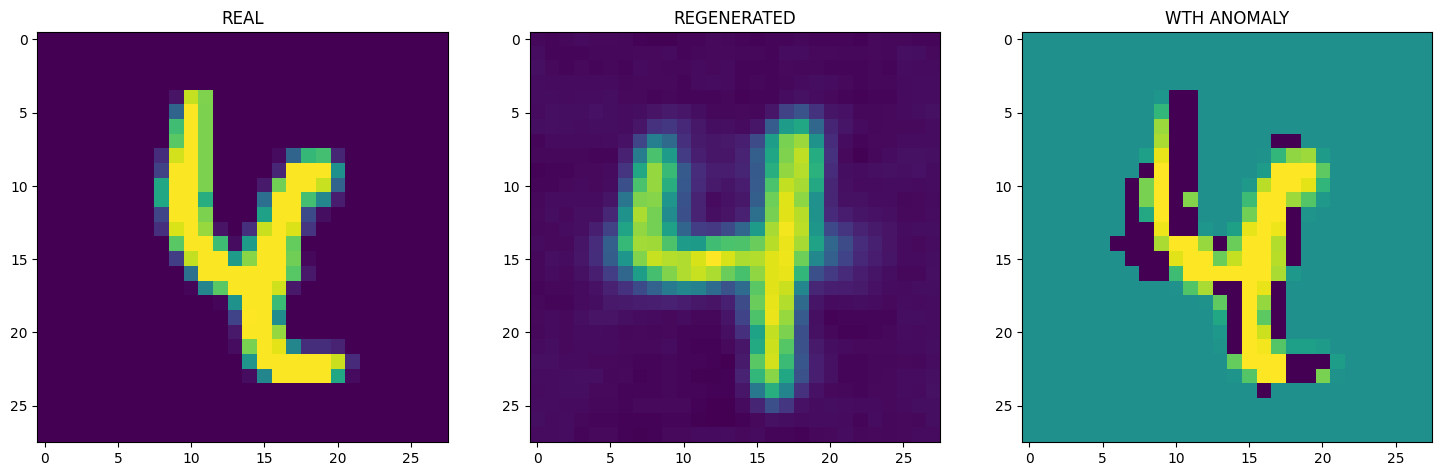

In [29]:
img = test_loader.dataset[160][0].view((-1, 1, 28, 28)).to(device)
#img  = torch.cat((img), dim=0)

r, fzd, _,_ = D(img)
gimg = G.main(fzd.reshape((-1, fuzzy_cores, 1, 1)))

data = img[0][0]
data = data - data.min(dim=1).values.min()
data = data/data.max(dim=1).values.max()

generated_image = gimg[0][0]
generated_image = generated_image - generated_image.min(dim=1).values.min()
generated_image = generated_image / generated_image.max(dim=1).values.max()


diff = (data - generated_image).abs()
anodet = torch.where(diff > 0.6, -1, data)

plt.figure(figsize=(18, 6))

R, C = 1, 3

plt.subplot(R, C, 1)
plt.title("REAL")
plt.imshow(data.detach().cpu().numpy())
plt.subplot(R, C, 2)
plt.title("REGENERATED")
plt.imshow(generated_image.detach().cpu().numpy())
plt.subplot(R, C, 3)
plt.title("WTH ANOMALY")
plt.imshow(anodet.detach().cpu().numpy())
arate = get_arate(img)
print(F"Anomaly : {arate > th_optimal} ({arate}/{th_optimal})")


tensor([2.7329], device='cuda:0', grad_fn=<SumBackward1>)

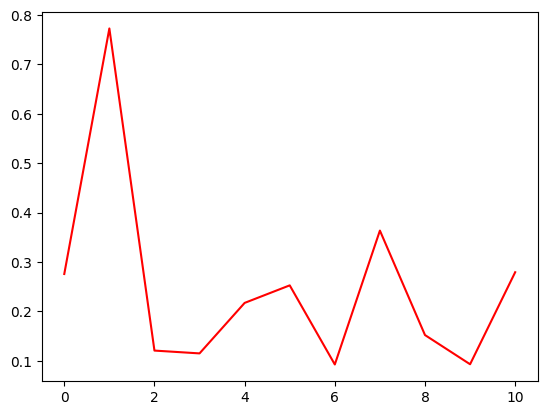

In [30]:
plt.plot(fzd[0].detach().cpu().numpy(), c="red")
#plt.plot(fzg[0].detach().cpu().numpy(), c="blue")
fzd.sum(-1)

EMNIST VIS:   0%|          | 0/40 [00:00<?, ?it/s]

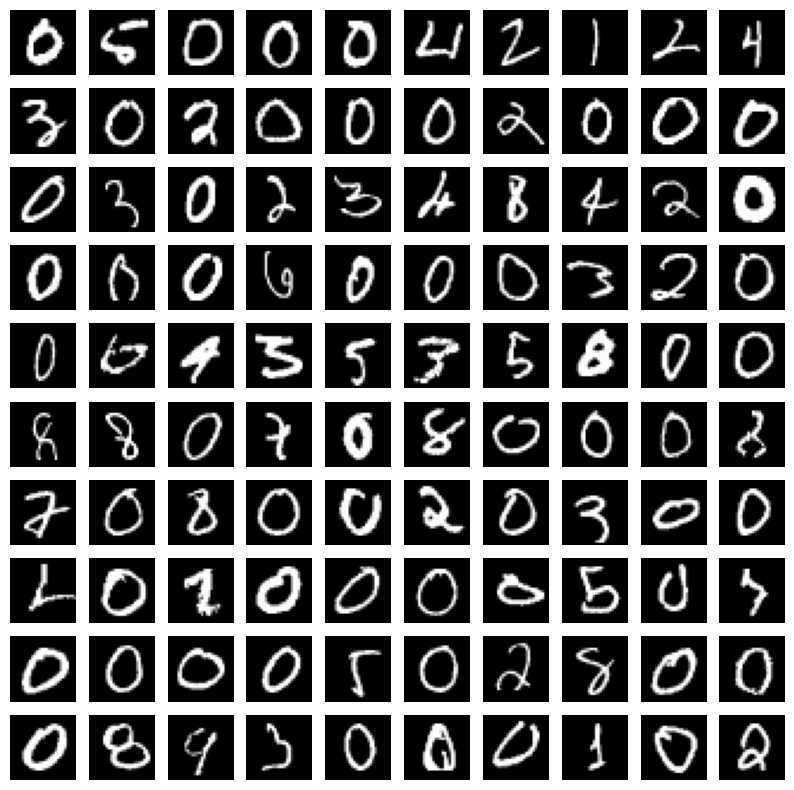

In [31]:
n = 0
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
with torch.no_grad():
    for data, labels in tqdm(test_loader, desc='EMNIST VIS'):
        if n >= 100:
            break
        data = data.view((-1, 1, 28, 28)).to(device) 
        
        arate = get_arate(data)
        
        for i in range(data.shape[0]):
            if(arate[i] > th_optimal):
                img = data[i]
                ax[int(n / 10), int(n % 10)].imshow(img.view(28, 28).cpu().detach().numpy(), cmap='gray')
                ax[int(n / 10), int(n % 10)].axis('off')
                n = n + 1
                    
                if n >= 100:
                    break